# IBM Streams PMML scoring sample application

This sample demonstrates creating a Streams Python application to perform scoring with a PMML model and viewing the results.


<ol>
<li><a href="#setup">Setup</a>
<ul>
<li>1.1. <a href="#setupStreams">Connection to Streams Instance</a></li>

<li>1.2. <a href="#setupPackages">Install additional packages</a></li>

<li>1.3. <a href="#setupDataModel">Add data and model</a></li>
</ul></li>
<li><a href="#create">Create the application</a>
<ul>
<li>2.1. <a href="#defineInput">Define Data Input</a></li>

<li>2.2. <a href="#analyzeData">Analyze Data (ML scoring)</a>
<ul>
    <li>2.2.1. <a href="#prepareData">Prepare Data for scoring</a></li>
    <li>2.2.2. <a href="#scoreData">Score Data</a></li>
</ul></li>
<li>2.3 <a href="#defineOutput">Define Data Output</a></li>
</ul>
<li><a href="#submit">Submit the application</a></li>

<li><a href="#view">Connect to the running application to view data</a></li>

<li><a href="#cancel">Stop the application</a></li>
</ol>
<a name="overview"></a>

# Overview

**About the sample**

This sample application is about using heart disease patients' health data and a Machine Learning (ML) model to determine the best drug treatment based on each patient's health records. 
The patient data includes age, sex, blood-pressure, cholesterol, sodium and potassium concentration and a reference drug. 

__Creating the model is not part of this notebook.__
This ML scenario is a sample scenario provided in IBM Cloud for creating a ML model inside Watson Studio with the SPSS Flow Modeler.
There you can learn how to create a trained model within IBM Cloud.

This application will show that ML scoring can be done within IBM Streams in real-time.


**How it works**

With the Streams Python API, we will define step by step a topology, which is a graph describing the flow of data in our streaming application through a number of processing functions. Running the Python code in the notebook will create this graph/flow and finally submit it to the Streams instance.

<img src="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/04/how-it-works.jpg" alt="How it works">

<br>
<br>


### Documentation & Information links

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [streamsx.topology Python API](https://streamsxtopology.readthedocs.io/)
- [streamsx.pmml Python API](https://streamsxpmml.readthedocs.io/)
- [PMML at Wikipedia](https://en.wikipedia.org/wiki/Predictive_Model_Markup_Language)
- [PMML specification at Data Mining Group](http://dmg.org/pmml/v4-3/GeneralStructure.html)






<a id="setup"></a>

# 1. Setup

  
  
<div class="alert alert-block alert-info">
<b>What do we need to set up for our sample application?</b>  
    
+ A connection to running <b>IBM Streams instance</b> <br> 
   This notebook describes using a Streams instance in IBM Cloud Pak for Data. 
+ <b>streamsx.topology</b> - the Python package providing the IBM Streams standard/basic function set
+ <b>streamsx.pmml</b> - the Python package providing the IBM Streams PMML scoring functionality
+ <b>Data set</b> with patient health data we will let "stream" through the application
+ <b>Trained PMML model</b> that will predict the best drug treatment for the patients 
</div>



<a id="setupStreams"></a>

### 1.1 Add credentials and connection information for the IBM Streams instance

This notebook is running in IBM Cloud Pak for Data and we are using an IBM Streams instance running in IBM Cloud Pak for Data. Getting all information needed to connect to the Streams instance here is simple.<br>
With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials and connection information for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.


<a id="setupPackages"></a>

## 1.2 Install or upgrade streamsx Python packages

As described in the [overview](#overview), we need the Python packages providing the Streams functionality to create streaming applications using Python, __streamsx__ and __streamsx.pmml__.<br>
The __streamsx__ should be at least 1.12.10 . Add the PMML scoring functionality by installing at least streamsx.pmml version 1.0.0 via `pip`.
 

In [ ]:
import sys
!{sys.executable} -m pip install --user --upgrade streamsx.pmml

# When you need to install a specific version of the package, run this line instead:
#!{sys.executable} -m pip install --user streamsx.pmml==somever

# show the installed versions of both packages
import streamsx.topology.context
import streamsx.pmml as pmml
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.pmml package version: " + pmml.__version__)

<a id="setupDataModel"></a>

## 1.3 Add data and model to your project

The PMML model and the data set of patient data need to be imported into the project. 

Importing models and data sets into your Cloud Pak project is fairly simple. Both are asset types which can be imported by drag'n'drop.

1. Download (right click -> Save As) the CSV data-set from GitHub: [Drug_dataset.csv](https://raw.githubusercontent.com/IBMStreams/pypi.streamsx.pmml/develop/sample/drug/Drug_dataset.csv)
2. Download (right click -> Save As) the PMML model xml file from GitHub: [Drug_pmml_model.xml](https://raw.githubusercontent.com/IBMStreams/pypi.streamsx.pmml/develop/sample/drug/Drug_pmml_model.xml)
3. Add the downloaded files to the project. with __Add data set__ and __Add model__ actions. Don't rename them. 
    - Upload the sample data set: click  __Add data set__ from the top right menu and browse to the downloaded  `Drug_dataset.csv` file:
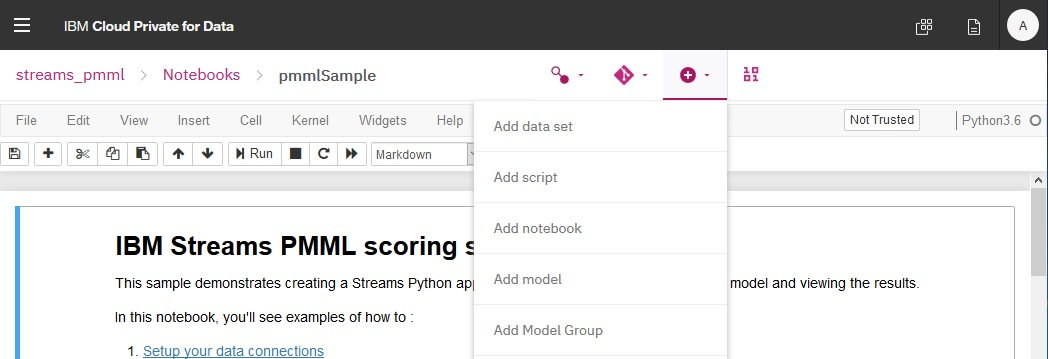
    
    - Next, upload the model:
        - Click  __Add model__ from the top right menu:
        - Select the model type, from the drop-down list select "PMML" and then browse to the downloaded `Drug_pmml_model.xml` file.  
        - After adding the model, you will see the metadata of the model the input-features(fields) and the output (predicted fields). These are  the fields we reference later when we define the mapping from input data to the model fields. 
<a id="modelMetadataPicture"></a>
        __Our model's metadata shown after importing the model file__
        
        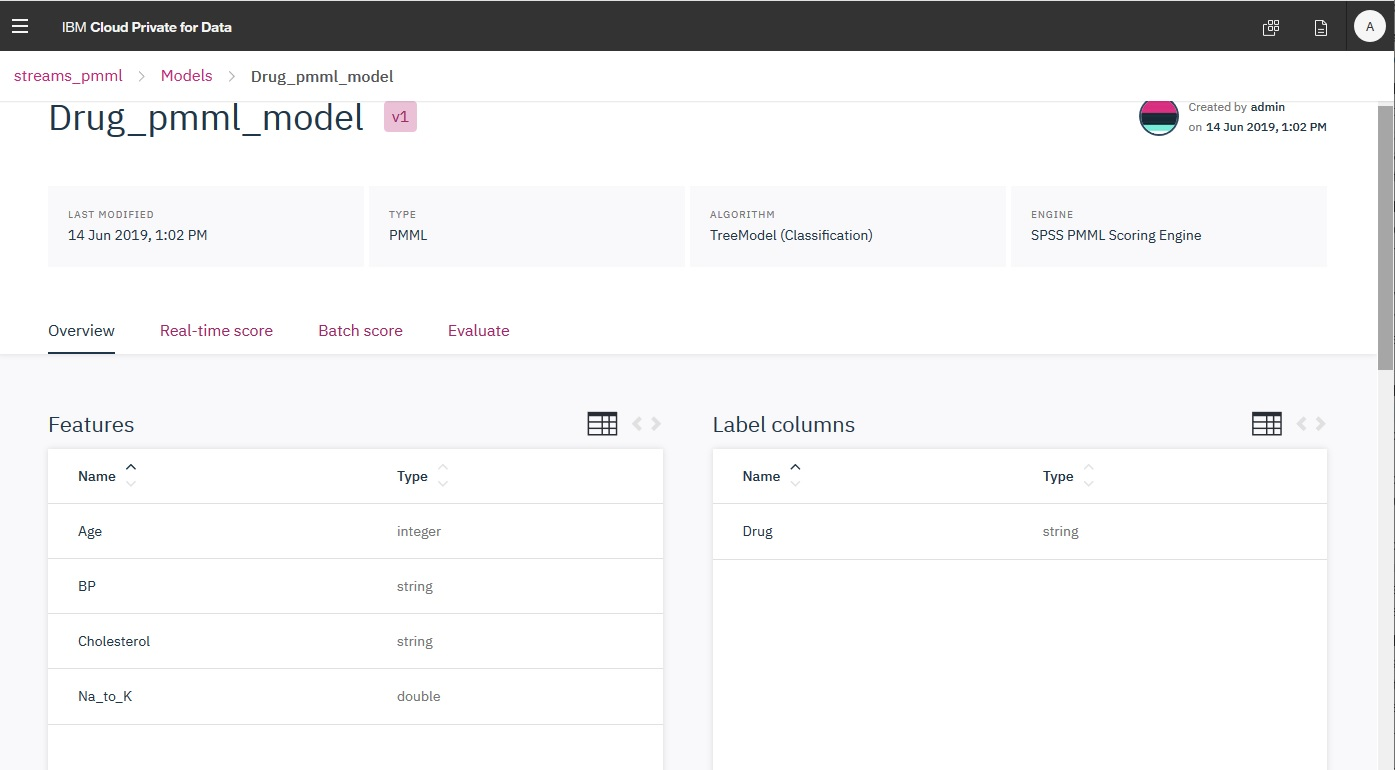
        - You come back to the notebook by clicking your project name in the navigation bar and the notebook afterwards.


<a id="create"></a>

# 2. Create the application


All Streams applications start with  a `Topology` object, so we start by creating one.<br>Additionally we add our data set to the topology as a dependency, which means that is bundled within the built application and so available at the environment where the application will run.

In [ ]:
from streamsx.topology.topology import Topology
import os

topo = Topology(name="PMMLScoring")

# add files to be contained in the archive which is deployed to the node running the application
# in this sample we need the `dataset` with sample data to be present at the worker node
topo.add_file_dependency(os.environ['DSX_PROJECT_DIR']+'/datasets/Drug_dataset.csv', 'etc')

<a id="defineInput"></a>

## 2.1 Define Data Input 

Let's take a look at the sample data, a set of patient medical records:

In [ ]:
sample_data = os.environ['DSX_PROJECT_DIR']+'/datasets/Drug_dataset.csv'
!head $sample_data

We will use this CSV file as data source for this sample. To simulate an endless stream of data we will read the file repeatedly and submit each line in the file as a tuple. The class below reads the data set and produces a stream of Python `dict` objects which also include 2 additional fields, `NA_to_K` and the prediction result `Drug`. The produced `Stream` is a stream of Python `dict`.

In [ ]:
import csv
from streamsx.ec import get_application_directory

# a class which can be used in topology as a source
class CSVFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
    def __call__(self):
        # Convert each row in the file to a dict
        drug_file =  os.path.join(get_application_directory(), "etc", self.file_name)
        col_names = ["age", "sex", "bloodPressure", "cholesterol", 
                     "bloodSodiumConcentration", "bloodPotassionConcentration", "referenceDrug"]
       
        # run this indefinitely so that there will always be data for the view
        while True:
            with open(drug_file) as handle:
                reader = csv.DictReader(handle, delimiter=',',
                                                fieldnames=col_names)
                #Use this to skip the header line if your file has one
                next(reader)
                #yield the lines in the file one at a time
                for row in reader:
                    yield dict(age= int(row["age"]),
                                     sex = row["sex"], 
                                    bloodPressure= row["bloodPressure"],
                                    cholesterol=row["cholesterol"] ,
                                    bloodSodiumConcentration=float(row["bloodSodiumConcentration"]),
                                    bloodPotassionConcentration=float(row["bloodPotassionConcentration"]),
                                    referenceDrug= row[ "referenceDrug"],
                                    #add placeholder attributes that will be computed later
                                    NA_to_K=0, predictedDrug="")

# let the csv file reader the source/edge node in our topology, producing the 'records' stream                    
records = topo.source(CSVFileReader("Drug_dataset.csv"))

<a id="analyzeData"></a>
## 2.2 Analyze and score data


Now that we have created a stream of patient records, we need to define the analytics we want to perform on our data. We want to use the PMML model to predict the best drug treatment based on the input stream data (patients' medical data).  

<div class="alert alert-block alert-info">
These are the core steps you need to use PMML model scoring in your application:
    
+ <b>Data preparation</b> <br> Make sure your input stream meets your model's expected input features
+ <b>Score using `streamsx.pmml.score()`, specifying: </b>
<br> - the model file to be used
<br> - the mapping from input stream fields to model input features
<br> - the mapping from output features to output stream fields

</div>
<br>

<a id="prepareData"></a>
### 2.2.1 Prepare data
Before scoring there is the need to make sure that your data is in the format that the model expects. 

First, our input data contains sodium and potassium concentration as separate attributes: `bloodSodiumConcentration` and `bloodPotassionConcentration`, but the model expects the quotient of both: NA/K.

We define the `NA_to_K` class to compute the Na/K value to each tuple from the input stream. This class will be invoked using the `map` function, which will be done later.

In [ ]:
# class providing a callable that calculates the NA / K ratio expected by the model
class NA_to_K():
    def __call__(self, frame):
        frame["Na_to_K"] = frame["bloodSodiumConcentration"] / frame["bloodPotassionConcentration"]
        return frame

Second, our input is a stream of Python `dict` objects, but  the `pmml.score()` function requires an input stream with a  [structured schema](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.schema.html#streamsx.topology.schema.StreamSchema).
In the cell below we first define the structured schema, and then:
- Add the Na/K feature to the input `Stream`
- Convert it to a `StructuredSchema`

Both steps are done by applying a `map()` function to the input `Stream`, `records`. The two `map()` calls can be chained and produce the `Stream` called `preprocess`.


In [ ]:
from streamsx.topology.schema import StreamSchema
# create streams schema for data from file
rawData = StreamSchema(
    "tuple<int32 age, rstring sex, rstring bloodPressure, rstring cholesterol, float64 bloodSodiumConcentration, float64 bloodPotassionConcentration,rstring referenceDrug>"
)
# extend the schema with preprocessed fields and scoring result fields
scoredData = rawData.extend(StreamSchema("tuple<float64 NA_to_K, rstring predictedDrug>"))    




# adding two map nodes to our topology:
#    - calculate Na to K 
#    - convert to structured schema
# generating the stream 'preprocess'
preprocess = records.map(NA_to_K()).map(lambda row: (row["age"], row["sex"],
                                                    row["bloodPressure"],
                                                   row["cholesterol"],
                                                   row["bloodSodiumConcentration"],
                                                   row["bloodPotassionConcentration"],
                                                   row[ "referenceDrug"],
                                                   row["Na_to_K"],row["predictedDrug"]),
                                        schema=scoredData)



<a id="scoreData"></a>
### 2.2.2 Score data
To invoke the `pmml.score` function to the `preprocess` stream, we need to:
1. Specify the model to be used with the `model_path` parameter. The path is relative to the notebook. To reference models in your Cloud Pak project use following schema:  
`../models/<yourModelName>/<yourModelVersion>/model`  
so for our sample:
`../models/Drug_pmml_sample/1/model`

2. Use the `model_input_attribute_mapping` parameter to define the mapping of the input stream fields to the model's input features. <br/>For example, comparing the model input features(fields) to the stream fields we produce, the input stream has the following fields:<br/>
`age, sex, bloodPressure, cholesterol, bloodSodiumConcentration, bloodPotassionConcentration, Na_to_K, referenceDrug,predictedDrug`. 
<br/> However, the model expects these features:
<br/> `Name,Age,BP, Cholesterol,Na_to_K`. This would be probably the normal case when using a model in an application, so we specify the mapping from fields in our stream to the input features the model expects.

3. Define the mapping of the model result to fields in the output stream with the `model_output_attribute_mapping` parameter. <br/>Depending on the used model algorithm ([model meta data picture](#modelMetaDataPicture)) the model output may generate a number of values, e.g. the `PredictedValue` itself but also the `Confidence` of this prediction. Both are sub-values (PMML defines them as `result features`) of the target, i.e. the PMML definition of the field being predicted. In this case our target is called `Drug` and we are only interested in the prediction, so we reference `Drug.PredictedValue` in our output mapping.


__Detailed documentation:__
+ [PMML streamsx package documentation](https://streamsxpmml.readthedocs.io/en/latest/)  for usage details of the streamsx.pmml.score() function
+ [IBM Streams PMML toolkit -  model types](https://www.ibm.com/support/knowledgecenter/SSCRJU_4.3.0/com.ibm.streams.tk20190528.doc/toolkits/dita/tk$com.ibm.streams.pmml/op$com.ibm.streams.pmml$PMMLScoring$1.html) for  supported model algorithms 
+ [IBM Streams PMML toolkit -  output features](https://www.ibm.com/support/knowledgecenter/SSCRJU_4.3.0/com.ibm.streams.tk20190528.doc/toolkits/dita/tk$com.ibm.streams.pmml/op$com.ibm.streams.pmml$PMMLScoring$2.html) for supported output features and their data types
+ [PMML Specification - output features](http://dmg.org/pmml/v4-3/Output.html) for PMML specified output features for the different scoring algorithms

In [ ]:
score = pmml.score(preprocess,
    schema=scoredData,
    model_path='../models/Drug_pmml_model/1/model', 
    model_input_attribute_mapping='Age=age,BP=bloodPressure,Cholesterol=cholesterol,Na_to_K=NA_to_K,Sex=sex', #
    model_output_attribute_mapping='predictedDrug=Drug.PredictedValue'
)

<a id="defineOutput"></a>
## 2.4 Define Output

The `score` stream is our final result.  We use `score.publish()` function to make this stream available to other applications. 

If you want to send the stream to another database or system, you would use a sink function (similar to the source function) and invoke it using e.g. `score.for_each`.



In [ ]:
import json

# publish results as JSON
score.publish(topic="ScoredRecords",schema=json,name="PublishScores")

# Other options include:
# invoke another sink function:
# score.for_each(func=send_to_db)
 

<b>Create a `View` to preview the tuples on the result `Stream` </b>


A `View` is a connection to a `Stream` that becomes activated when the application is running. It provides an interface to get snapshots of the data flowing on this stream. We examine the data from within the notebook in section 4, below.

In [ ]:
score_view = score.view(name="ScoredRecords", description="Sample of scored records")

<a name="submit"></a>

# 3. Submit the application
A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.


In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

# build and submit
submission_result = context.submit('DISTRIBUTED', 
                                   topo, 
                                   cfg)

print(submission_result)
# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: ", submission_result.job.id , "Name: ", submission_result.job.name)


<a name="view"></a>

# 4. Use the `View` to access data from the job
Now that the job is started, use the `View` object you created in step 2.3 to start retrieving data from a `Stream`.   
   
Compare the attributes 'referenceDrug' and 'predictedDrug' in the output below. The predicted drug is the result of the scoring. Both values should be equal.

In [ ]:
# Connect to the view and display the data
queue = score_view.start_data_fetch()
try:
    for val in range(10):
        print(queue.get())    
finally:
    score_view.stop_data_fetch()

<b> Display the results in real time</b>  

Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.

In [ ]:
# Display the results for 30 seconds
score_view.display(duration=30)

<b> See job status </b>  

You can view job status and logs by going to **My Instances** > **Jobs**. Find your job based on the id printed above.
Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the Streams Console.  Go to **My Instances** > **Provisioned Instances**. Select the Streams instance and open the URL listed under *externalConsoleEndpoint* or *serviceConsoleEndpoint*.

<a name="cancel"></a>

# 5. Cancel the job

This cell generates a widget you can use to cancel the job.

In [ ]:
#cancel the job in the IBM Streams service
submission_result.cancel_job_button()

You can also interact with the job through the [Job](https://streamsxtopology.readthedocs.io/en/stable/streamsx.rest_primitives.html#streamsx.rest_primitives.Job) object returned from `submission_result.job`

For example, use `job.cancel()` to cancel the running job directly.

# Summary

We started with a `Stream` called `records`, which contained the data we wanted to analyze. Next, we used functions in the `Stream` object to perform simple preprocessing before we scored the data with a ML model and produced the `score` stream.

After submitting the application to the Streams service, we connected to the `score_view` view to see the results within the notebook.